
<font size = "5"> **Chapter 2: [Diffraction](../Diffraction/CH2_00-Diffraction.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />

# HW3:  Analyzing Spot and CBED Pattern

[Download](https://raw.githubusercontent.com/gduscher/MSE672-Introduction-to-TEM//main/Homework/Homework03-KinematicDiffraction.ipynb)

[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/gduscher/MSE672-Introduction-to-TEM/blob/main/Homework/Homework03-KinematicDiffraction.ipynb)
 
part of 

<font size = "5"> **[MSE672:  Introduction to Transmission Electron Microscopy](../_MSE672_Intro_TEM.ipynb)**</font>

**Spring 2024**
<table style="margin-right:auto;margin-left:0px">
  <tr>
    <td>Gerd Duscher </td>
    <td>Khalid Hattar</td>
  </tr>
  <tr>
    <td>Microscopy Facilities</td> 
    <td> Tennessee Ion Beam Materials Laboratory </td>
  </tr>
  
  <tr>
    <td>Materials Science & Engineering</td>
    <td> Nuclear Engineering</td>
  </tr>
  <tr>
    <td>Institute of Advanced Materials & Manufacturing</td>
    <td> </td>
  </tr>
  <tr>
    <td colspan="2"><center> The University of Tennessee, Knoxville</center> </td>
  </tr>
</table>

Background and methods to analysis and quantification of data acquired with transmission electron microscopes

## Load relevant python packages
### Check Installed Packages

In [1]:
import sys
from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = get_distribution(package_name).version
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version


# pyTEMlib setup ------------------
if test_package('pyTEMlib') < '0.2024.2.3':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install  --upgrade SciFiReaders -q
    !{sys.executable} -m pip install  --upgrade pyTEMlib -q
# ------------------------------
print('done')

done


### Import numerical and plotting python packages
Import the python packages that we will use:

Beside the basic numerical (numpy) and plotting (pylab of matplotlib) libraries,

and some libraries from the book
* kinematic scattering library.
* file_tools library

In [1]:
%matplotlib  widget
import matplotlib.pyplot as plt
import numpy as np
import sys

if 'google.colab' in sys.modules:
    from google.colab import output
    output.enable_custom_widget_manager()
    from google.colab import drive

# additional package 
import os
import  itertools 
import scipy.constants as const

import ipywidgets as ipyw

import sidpy
import pyTEMlib
import pyTEMlib.kinematic_scattering as ks         # kinematic scattering Library
                             # atomic form factors from Kirkland's book
import pyTEMlib.file_tools 

print(pyTEMlib.__version__)

You don't have igor2 installed.     If you wish to open igor files, you will need to install it     (pip install igor2) before attempting.
You don't have gwyfile installed.     If you wish to open .gwy files, you will need to      install it (pip install gwyfile) before attempting.
Symmetry functions of spglib enabled
Using kinematic_scattering library version {_version_ }  by G.Duscher
0.2024.02.2


## Load CBED Pattern
>
>Please note, that this notebook will not work in Google colab becaus of the ``open file dialog``
>
First we select the diffraction pattern

In [2]:
# ------Input -------------
load_your_own_data = True
# -------------------------
if 'google.colab' in sys.modules:
    drive.mount("/content/drive")
    load_your_own_data = True
if load_your_own_data:
   fileWidget = pyTEMlib.file_tools.FileWidget(sum_frames=True)
    

We are making a dataset of the diffraction pattern with the correct dimensions and some additional information in the metadata.

Make sure to check the tilt angles.

Do not panic if you do not see much here, we are on a linear scale look for the logarithmic scale below.

alpha tilt 13.83°
beta tilt -7.16°


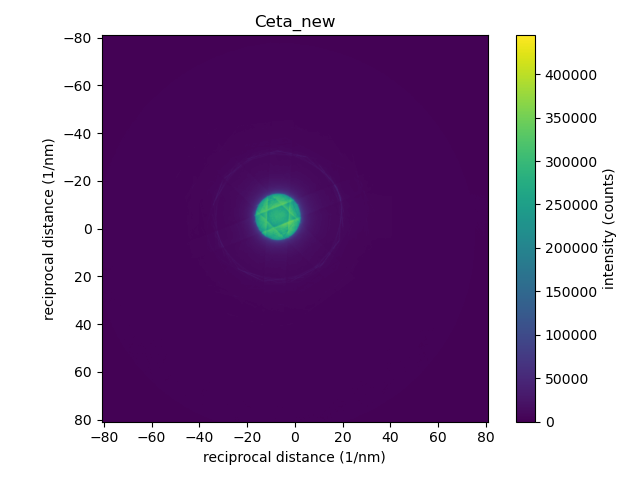

In [3]:
diff_pattern = fileWidget.selected_dataset
diff_pattern -= diff_pattern.min()
print(f"alpha tilt {np.degrees(diff_pattern.metadata['experiment']['stage']['tilt']['alpha']):.2f}°")  
print(f"beta tilt {np.degrees(diff_pattern.metadata['experiment']['stage']['tilt']['beta']):.2f}°")  
view = diff_pattern.plot()

In [6]:
diff_pattern.view_metadata()

experiment :
	detector : BM-Ceta
	acceleration_voltage : 200000.0
	microscope : Titan
	start_date_time : 1708464582
	probe_mode : parallel
	convergence_angle : 0.0
	stage :
		holder : 
		position :
			x : -4.7586555000000006e-05
			y : -9.790516799999993e-05
			z : -0.00026039325
		tilt :
			alpha : 0.24136012699999992
			beta : -0.12500984966754913


### Plotting on a logarithmic scale

The dynamic range in diffraction data is even larger than in images and so for a good presentation of the data it is advantagous to go to plot the intensities in a logarythmic scale.

To present data in logarythmic scale no nexgative values (noise) can be in these data and so all negative values in the dataset will be set to zero.

The factor 1 in front of the diffraction pattern in the log numpy function in the ``imshow`` is the gamma value.
Changing that value will change the contrast.

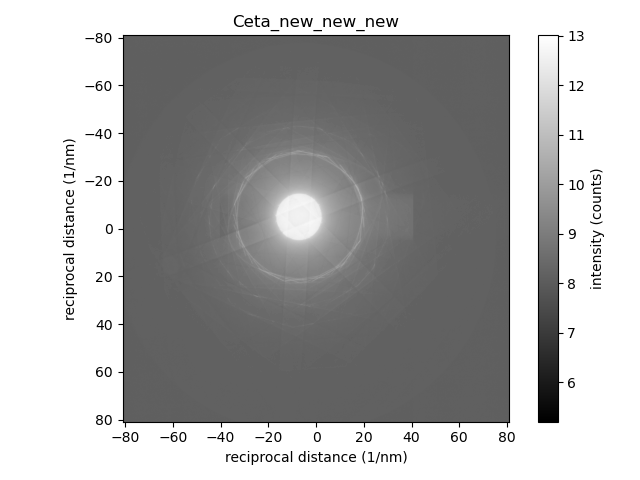

In [7]:
view = np.log(1+diff_pattern).plot(cmap='gray', vmin=np.max(np.log(1+diff_pattern))*0.4);

## Finding the center

### Selection of  center disk

Select the center disk with the ring selector.
For the Spectra 300 we just use the maximum.

The ring selector can also be used to measure HOLZ ring diameters and convergence angles.


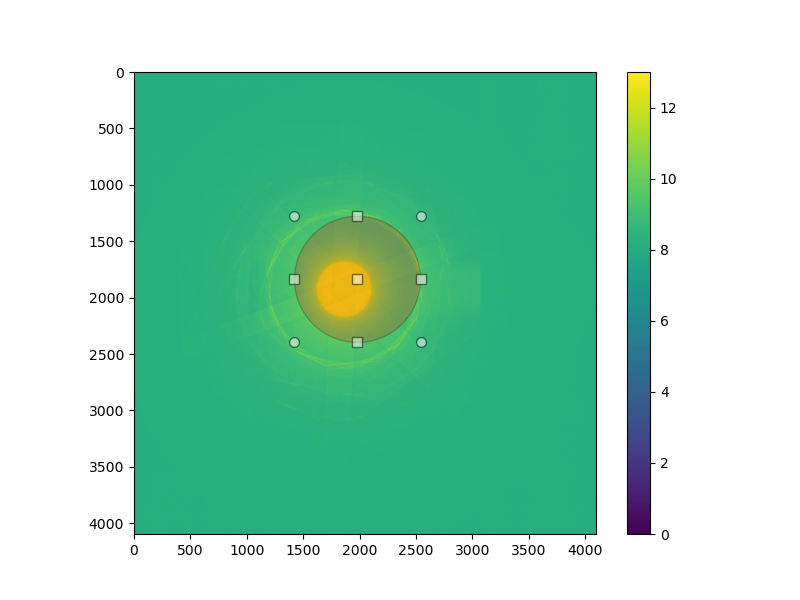

In [9]:
from matplotlib.widgets import  EllipseSelector

center = np.unravel_index(np.argmax(np.array(diff_pattern)),diff_pattern.shape)

plt.figure(figsize=(8, 6))
extent = diff_pattern.get_extent([0,1])

im = plt.imshow(np.log(1+diff_pattern).T, origin = 'upper')
plt.colorbar(im)
selector = EllipseSelector(plt.gca(), None,interactive=True)  # gca get current axis (plot)
radius = 559 
center = np.array(center)

selector.extents = (center[0]-radius,center[0]+radius,center[1]-radius,center[1]+radius)


### Read out center and radius

In [10]:
xmin, xmax, ymin, ymax = selector.extents
x_center, y_center = selector.center
x_shift = x_center - diff_pattern.shape[0]/2
y_shift = y_center - diff_pattern.shape[1]/2
print(f'radius x-direction = {(xmax-xmin)/2:.0f} pixels')
print(f'radius y-direction = {(ymax-ymin)/2:.0f} pixels')

center = (x_center, y_center )
print(f'new center = {center} [pixels]')

out_tags ={}
out_tags['center'] = center

radius x-direction = 559 pixels
radius y-direction = 559 pixels
new center = (1883.4761904761904, 1900.0606060606065) [pixels]


## Calculate Spot Pattern

see [Plotting of Diffraction Pattern](../Diffraction/CH2_08-Spot_Diffraction_Pattern.ipynb) for details

Make sure the experimental parameters are correct for our experiment, especially zone_axis, excitation error and acceleration voltage


In [11]:
#Initialize the dictionary of the input
tags_experiment = {}
### Define Crystal
atoms  = ks.structure_by_name('silicon')

### Define experimental parameters:
tags_experiment['acceleration_voltage_V'] = 200.0 *1000.0 #V
tags_experiment['new_figure'] = False
tags_experiment['plot FOV'] = 30
tags_experiment['convergence_angle_mrad'] = 0
tags_experiment['zone_hkl'] = np.array([0, 1, 1])  # incident neares zone axis: defines Laue Zones!!!!
tags_experiment['mistilt']  = np.array([0, 0, 0])  # mistilt in degrees
tags_experiment['Sg_max'] = .4 # 1/nm  maximum allowed excitation error ; This parameter is related to the thickness
tags_experiment['hkl_max'] = 15   # Highest evaluated Miller indices

atoms.info['experimental'] = tags_experiment
######################################
# Diffraction Simulation of Crystal #
######################################

ks.kinematic_scattering(atoms, verbose=False)


## Plotting Experimental and Simulated Spot Diffraction Patterns


Change the inut so that the diffraction pattern and the simulation match.

Scale is 0.0040 1/nm per pixel


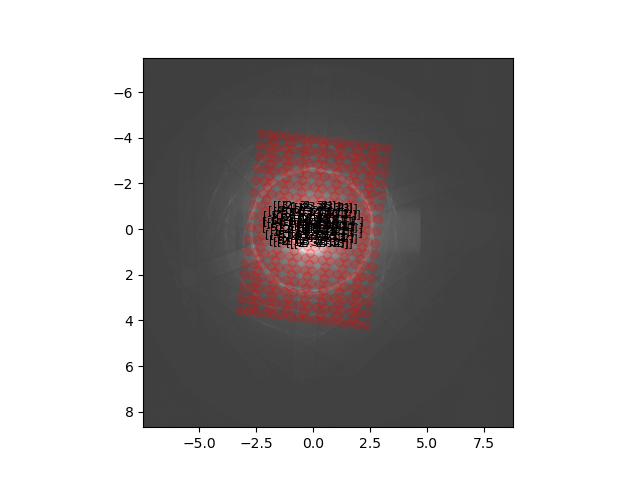

In [12]:
# ----- Input ---------
rotation_angle = -7 # in degrees
convergence_angle = .04  # in 1/nm
pixel_size = pyTEMlib.file_tools.get_slope(diff_pattern.x.values) *1.01
# -------------------
tags_simulation = atoms.info['diffraction']

g = gx = gy = pixel_size/10

print(f'Scale is {g:.4f} 1/nm per pixel')
extent= np.array([-center[0]*gx, (diff_pattern.shape[0]-center[0])*gx,(diff_pattern.shape[1]-center[1])*gy, -center[1]*gy])

# rotation matrix  around z axis to coincide with spots
angle = np.radians(rotation_angle)
c = np.cos(angle)
s = np.sin(angle)
r_mat = np.array([[c,-s,0],[s,c,0],[0,0,1]])
rotation_matrix = r_mat


spots_simulation =  np.dot(tags_simulation['allowed']['g'], rotation_matrix)
spots_ZOLZ = spots_simulation[tags_simulation['allowed']['ZOLZ']]
fig = plt.figure()
#fig.suptitle(' SAED in ' + str(tags_experiment['zone_hkl']), fontsize=20) 
plt.scatter(spots_ZOLZ[:,0], spots_ZOLZ[:,1], c='red',  alpha = 0.2,   label='spots')
plt.imshow(np.log2(1+diff_pattern).T,cmap="gray", extent=(extent), vmin=np.max(np.log2(1+diff_pattern))*0.5);

for i in range(len(tags_simulation['allowed']['g'])):
    if np.linalg.norm(tags_simulation['allowed']['g'][i]) <1:
        disk = plt.Circle((spots_simulation[i,0], spots_simulation[i,1] ), convergence_angle, alpha=0.3)
        plt.gca().add_artist(disk) 
        plt.text(spots_simulation[i,0], spots_simulation[i,1],str(tags_simulation['allowed']['hkl'][i]),
                fontsize = 8, horizontalalignment = 'center', verticalalignment ='bottom')
    

### What does the above figure convey?




### What is the accuracy?




## Conclusion

We need more information for the spot pattern than for the ring pattern.

The convergent beam pattern has the same kinematic diffraciton information but provides additional dynamical diffraction information.

A comparison between simulation and experiment can be very precise.

In principle, if you have the spots and the approximate center you can let an optimization routine do all the scaling for you (which we will do in the high resultion imaging section).



In [ ]:
'BinaryResult': {'AcquisitionUnit': 'CameraImage',
  'CompositionType': '',
  'ImageSize': {'width': '4096', 'height': '4096'},
  'DetectorIndex': '1',
  'Detector': 'BM-Ceta',
  'PixelSize': {'width': '39522493.905830137', 'height': '39522493.905830137'},
  'PixelUnitX': '1/m',
  'PixelUnitY': '1/m',
  'Offset': {'x': '-80942067519.140121', 'y': '-80942067519.140121'},

0.03952249390583014